In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
SEED = 2018
random.seed(SEED)
np.random.seed(SEED)

In [3]:
dataset = load_boston()
X, y = dataset.data, dataset.target
features = dataset.feature_names

In [4]:
est = LinearRegression()
score = -1.0 * cross_val_score(est, X, y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))

CV MSE before feature selection: 37.13


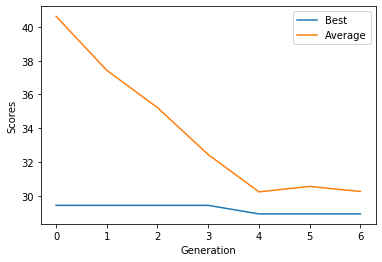

CV MSE after feature selection: 28.92


In [5]:
class GeneticSelector():
    def __init__(self, estimator, n_gen, size, n_best, n_rand, 
                 n_children, mutation_rate):
        # Estimator 
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate
        
        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")  
            
    def initilize(self):
        population = []
        for i in range(self.size):
            chromosome = np.ones(self.n_features, dtype=np.bool)
            mask = np.random.rand(len(chromosome)) < 0.3
            chromosome[mask] = False
            population.append(chromosome)
        return population

    def fitness(self, population):
        X, y = self.dataset
        scores = []
        for chromosome in population:
            score = -1.0 * np.mean(cross_val_score(self.estimator, X[:,chromosome], y, 
                                                       cv=5, 
                                                       scoring="neg_mean_squared_error"))
            scores.append(score)
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds]), list(population[inds,:])

    def select(self, population_sorted):
        population_next = []
        for i in range(self.n_best):
            population_next.append(population_sorted[i])
        for i in range(self.n_rand):
            population_next.append(random.choice(population_sorted))
        random.shuffle(population_next)
        return population_next

    def crossover(self, population):
        population_next = []
        for i in range(int(len(population)/2)):
            for j in range(self.n_children):
                chromosome1, chromosome2 = population[i], population[len(population)-1-i]
                child = chromosome1
                mask = np.random.rand(len(child)) > 0.5
                child[mask] = chromosome2[mask]
                population_next.append(child)
        return population_next
	
    def mutate(self, population):
        population_next = []
        for i in range(len(population)):
            chromosome = population[i]
            if random.random() < self.mutation_rate:
                mask = np.random.rand(len(chromosome)) < 0.05
                chromosome[mask] = False
            population_next.append(chromosome)
        return population_next

    def generate(self, population):
        # Selection, crossover and mutation
        scores_sorted, population_sorted = self.fitness(population)
        population = self.select(population_sorted)
        population = self.crossover(population)
        population = self.mutate(population)
        # History
        self.chromosomes_best.append(population_sorted[0])
        self.scores_best.append(scores_sorted[0])
        self.scores_avg.append(np.mean(scores_sorted))
        
        return population

    def fit(self, X, y):
 
        self.chromosomes_best = []
        self.scores_best, self.scores_avg  = [], []
        
        self.dataset = X, y
        self.n_features = X.shape[1]
        
        population = self.initilize()
        for i in range(self.n_gen):
            population = self.generate(population)
            
        return self 
    
    @property
    def support_(self):
        return self.chromosomes_best[-1]

    def plot_scores(self):
        plt.plot(self.scores_best, label='Best')
        plt.plot(self.scores_avg, label='Average')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Generation')
        plt.show()

sel = GeneticSelector(estimator=LinearRegression(), 
                      n_gen=7, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)
sel.fit(X, y)
sel.plot_scores()
score = -1.0 * cross_val_score(est, X[:,sel.support_], y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE after feature selection: {:.2f}".format(np.mean(score)))